# Introduction To Financial Mathematics

This notebook will give you an introduction into core concepts in financial mathematics, along with formulas and Python implementations. You will learn how to calculate (compound) interest, price options, option trading strategies, option portfolio hedging and basic risk management calculations. Some concepts will look complex at first, but become clear once you learn the intuition behind it and compare the formulas to the code. Let's dive into financial mathematics!

## Dependencies

As we will code the concepts from scratch we will use only basic Python libraries:

- NumPy for linear algebra
- Matplotlib for visualization
- Scipy for optimization and probability distributions.

In [5]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import norm
from scipy.optimize import minimize

In [4]:
pip install scipy

     ---------------------------------------- 42.5/42.5 MB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Interest

One of the most fundamental concepts in financial mathematics is interest. A lot of investments are judged on percentage-wise returns and how they compound over time (i.e. build interest on interest). Investments are often compared to a "risk-free interest rate" $r_f$. This is the baseline of what we can earn on capital without risking its loss. $r_f$ changes over time and can even become negative as we have seen in recent years. In practice, assets like [US Treasury bonds](https://en.wikipedia.org/wiki/United_States_Treasury_security) are often regarded as risk-free, even though default is technically possible. 

To calculate interest our input parameters are interest rate $r$, Present Value $PV$ and $n$ periods (often expressed in years). With these values we can calculate future value $FV$. 

By rewriting the equation we can also derive $PV$ from $FV$. Lastly, we can derive the needed interest $r$ if we know both the desired $PV$ and $FV$.

In [2]:
starting_capital = 1000 # PV
r = 0.05 # 5% interest
n = 50 # Years

### Simple interest

The easiest calculations will be for a percentage interest without compounding.

$FV = (1+rn)PV$

$PV = \frac{FV}{1+rn}$

$r = \frac{\frac{FV}{PV} - 1}{n}$

In [3]:
def fv_simple(pv: float, r: float, n: int):
    return (1+r*n)*pv

def pv_simple(fv: float, r: float, n: int):
    return fv / (1 + r * n)
    
def r_simple(pv: float, fv: float, n: int):
    return (fv/pv - 1) /  n

In [4]:
fv = fv_simple(starting_capital, r, n)
fv

3500.0

In [5]:
pv = pv_simple(fv, r, n)
pv

1000.0

In [6]:
r_simple(pv, fv, n)

0.05

### Compound Interest

The simple formula above works for the case where we only get interest on the initial investment and does not take into account compound interest. The next equation takes compounding over $n$ periods into account. Note that this leads to a higher return.

$FV = (1+r)^nPV$

$PV = \frac{FV}{(1+r)^n}$

$r = \sqrt[n]{\frac{FV}{PV}} - 1$

In [7]:
def fv_compound(pv, r: float, n: int):
    return pv * (1+r)**n

def pv_compound(fv: float, r: float, n: int):
    return fv / (1 + r)**n

def r_compound(pv: float, fv: float, n: int):
    return (fv/pv)**(1/n) - 1

In [8]:
fv = fv_compound(starting_capital, r, n)
fv

11467.399785753702

In [9]:
pv = pv_compound(fv, r, n)
pv

1000.0000000000001

In [10]:
r_compound(pv, fv, n)

0.050000000000000044

### Periodic Interest

In some cases we receive interest more than once a year, for example every month. To take this into account we introduce a parameter $m$ that indicates how many times a year we receive the interest. The higher $m$ is, the faster our investment can compound.

$FV = (1 + \frac{r}{m})^{mn}PV$

$PV = \frac{FV}{(1 + \frac{r}{m})^{mn}}$

$r = (\sqrt[mn]{\frac{FV}{PV}} - 1)m$

In [11]:
m = 12 # Monthly compounding

In [12]:
def fv_interval(pv: float, r: float, n: int, m: int):
    return ((1 + r / m)**(m * n)) * pv

def pv_interval(fv: float, r: float, n: int, m: int):
    return fv / (1+r/m)**(m*n)

def r_interval(pv: float, fv: float, n: int, m: int):
    return ((fv / pv)**(1/(m*n)) - 1)* m

In [13]:
fv = fv_interval(starting_capital, r, n, m)
fv

12119.383211406064

In [14]:
pv = pv_interval(fv, r, n, m)
pv

1000.0000000000001

In [15]:
r_interval(pv, fv, n, m)

0.04999999999999982

### Continuous Interest

As $m$ goes to infinity ($\underset{m \to \infty}{lim}$) we encounter the notion of "continuous compounding". While this notion sounds abstract, continuous compounding is an important concept for financial theory and models that treat financial time series as continuous.

$FV = e^{rn}PV$

$PV = \frac{FV}{e^{rn}}$

$r = \frac{ln(\frac{FV}{PV})}{n}$

In [16]:
def fv_continuous(pv: float, r: float, n: int):
    return np.exp(r * n) * pv

def pv_continuous(fv: float, r: float, n: int):
    return fv / np.exp(r * n)

def r_continuous(pv: float, fv: float, n: int):
    return np.log(fv/pv) / n

In [17]:
fv = fv_continuous(starting_capital, r, n)
fv

12182.493960703474

In [18]:
pv = pv_continuous(fv, r, n)
pv

1000.0000000000001

In [19]:
r_continuous(pv, fv, n)

0.05

### Interest with periodic deposit

In practical scenarios we periodically add money to our investment. This practice is also popularly known as [Dollar-Cost Averaging (DCA)](https://www.investopedia.com/terms/d/dollarcostaveraging.asp). We define $A$ as the amount we periodically add and augment our periodic interest equation to account for this.

$FV = \frac{A}{r/m}((1 + \frac{r}{m})^{mn} - 1)$

$PV = \frac{A}{r/m}(1 - \frac{1}{(1+r/m)^{mn}})$

In [20]:
A = 100. # Monthly added deposit

In [21]:
def fv_with_deposit(r: float, n: int, m: int, a: float):
    return (a / (r/m)) * ((1 + r/m)**(m*n) - 1)

def pv_with_deposit(r: float, n: int, m: int, a: float):
    return (a / (r/m)) * (1 - 1 / (1 + r / m)**(m*n))

In [22]:
fv = fv_with_deposit(r, n, m, A)
fv

266865.19707374554

In [23]:
pv_with_deposit(r, n, m, A)

22019.7012024991

## Options

An option is a financial derivative that gives you the right, but not the obligation, to buy some underlying asset like a stock.

Derivatives are financial products that derive their value based on some underlying asset. Common parameters that are important for this valuation are:
- Underlying asset price
- Volatility of underlying asset (standard deviation)
- Time until expiration of derivative
- Strike price (A cut-off value for option that are introduced in the following sections)
- Risk-free interest rate

In this notebook we will analyze European options, which give the buyer the right to buy or sell a certain stock for a given price on a certain date. An option for buying is called a [Call option](https://www.investopedia.com/terms/c/calloption.asp). The right to sell is called a [Put option](https://www.investopedia.com/terms/p/putoption.asp). 

There are two popular ways to determine the price of an option:
1. Binomial Lattice
2. Black-Scholes

The mathematics and calculation of Black-Scholes is more involved so we start with explaining how a binomial lattice works.

## Binomial Lattice (European Call option)

The binomial lattice model simplifies pricing by assuming a stock either goes up or down a certain amount in a time-period. We assume the price of a stock follows a random path. Each node in the lattice will represent the possible stock price at a given point in time. We then recursively compute time-steps until we can compute the fair price of an option. Like with interest calculations, everything is discounted over time using a risk-free interest rate $r$.
The price will mainly be based on $K$ (Strike price) and $S$ = (Stock price at start)

We assume for each time-period a stock goes up or down a certain percentage. These movements are defined by $u$ (Up scenario) and $d$ (Down scenario), where $u > 1$ and $d < 1$. How far a stock can move will depend on the volatility $\sigma$ and the time-period $\Delta t$.

$u = e^{\sigma \sqrt{\Delta}t}$

$d = e^{-\sigma \sqrt{\Delta}t}$

In [24]:
var = 0.2 # Variance
sigma = np.sqrt(var) # Standard deviation
S = 44 # Stock price
K = 45 # Strike price
T = 2/12 # Time period (two months = two steps)
r = 0.06 # Risk-free interest rate
delta_t = 1/12 # time-steps of one month
R = np.exp(r * delta_t) # Discounted interest

u = np.exp(sigma*np.sqrt(delta_t)) # Up scenario
d = np.exp(-sigma*np.sqrt(delta_t)) # Down scenario

def price_binomial(R, Pu, Pd, u, d):
    """ Compute option price for a step """
    q = (R-d)/(u-d)
    return (1/R) * (q * Pu + (1-q)*Pd)

### Two-step call option price

As a simple example we compute the price of a call option based on two steps of one month. This requires us to start at the end of the tree and compute $C_{ud}$ (One up scenario and one down), $C_{uu}$ (Two times down) and $C_{dd}$ (Two times up). These are all the possible scenarios after two time steps. We then use the result to compute $C_u$ and $C_d$, which are all the scenarios after one step. After this we can finally calculate $C$, which denotes the fair price of an option given all possible scenarios. Note that this setup is very simple and does not reflect reality where many other scenarios can happen. Still, the Binomial lattice gives us a good indication on how much an option if worth. Professional option traders will run software with many more time-steps and run the calculations for various values of $u$ and $d$.

$C_{ud} = max\{Sud - K, 0\}$

$C_{uu} = max\{Su^2 - K, 0\}$

$C_{dd} = max\{Sd^2 - K, 0\}$

In [25]:
c_ud = np.maximum(0, u * d * S - K)
c_uu = np.maximum(0, u**2 * S - K)
c_dd = np.maximum(0, d**2 * S - K)

$C_u = \frac{1}{R}(q C_{uu} + (1-q)C_{ud})$

$C_d = \frac{1}{R}(q C_{ud} + (1-q)C_{dd})$

$C = \frac{1}{R}(q C_{u} + (1-q)C_{d})$


where $q = \frac{R - d}{u - d}$ and $R = e^{r \Delta t}$.

In [26]:
Cu = price_binomial(R, c_uu, c_ud, u, d)
print(f"Option price for 1-step up scenario: {Cu.round(2)}")

Option price for 1-step up scenario: 5.8


In [27]:
Cd = price_binomial(R, c_ud, c_dd, u, d)
print(f"Option price for 1-step down scenario: {Cd.round(2)}")

Option price for 1-step down scenario: 0.0


In [28]:
C = price_binomial(R, Cu, Cd, u, d)
print(f"Fair option price given all scenario's: {C.round(2)}")

Fair option price given all scenario's: 2.81


## Binomial Lattice plotting

To get a clearer overview of the binomial lattice we can visualize the tree on which price calculation is based. It also allows us to analyze what returns are assumed for the up and down scenario after a time step.

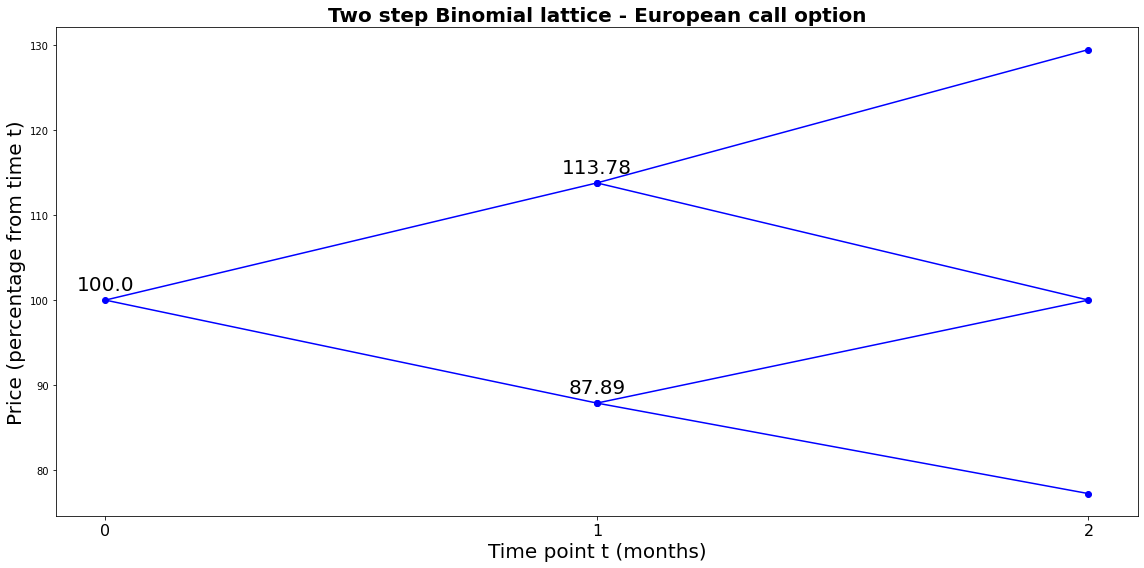

In [29]:
fig = plt.figure(figsize=[16, 8])
for i in range(2):
    x = [1, 0, 1]
    for j in range(i):
        x.append(0)
        x.append(1)
    x = np.array(x) + i
    y = np.arange(-(i+1), i+2)[::-1]
    y = 100 * np.power(u, y)
    plt.plot(x, y, 'bo-')
    if i % 2 == 0:
        for x_pos, y_value in zip(x,y):
            plt.annotate(y_value.round(2), 
                         (x_pos, y_value), 
                         textcoords="offset points",
                         xytext=(0, 10), 
                         ha='center', fontsize=20)
plt.xlabel('Time point t (months)', fontsize=20)
plt.ylabel('Price (percentage from time t)', fontsize=20)
plt.xticks([0, 1, 2], fontsize=16)
plt.title('Two step Binomial lattice - European call option', fontsize=20, weight='bold')
plt.tight_layout()

## Black-Scholes

Black-Scholes is a formula to derive the price of an option based on stochastic calculus. The derivation of the formula can be daunting, so we start first with learning how to apply the formula and express it as Python code.

In 1969, [Edward Thorp](https://en.wikipedia.org/wiki/Edward_O._Thorp) discovered what came to be known as Black-Scholes and used it for his investing, but did not publish a paper on it. In 1973, [Fischer Black](https://en.wikipedia.org/wiki/Fischer_Black) and [Myron Scholes](https://en.wikipedia.org/wiki/Myron_Scholes) published their Black-Scholes model. In 1974 it was further formalized and worked out by [Robert C. Merton](https://en.wikipedia.org/wiki/Robert_C._Merton).

$S_t$ = Stock price at time $t$, $K$ = Strike price of option, $T$ is time till expiration in years, $r$ = risk-free interest rate $\sigma$ = standard deviation (i.e. volatility).

$\Phi$ denotes the Cumulative Density Function (CDF) of the standard normal distribution ($N(0, 1)$).


$C(S_t, t) = \Phi(d_1^{(t)})S_t - \Phi(d_2^{(t)})Ke^{-rT}$

$P(S_t, t) = \Phi(-d_2^{(t)})Ke^{-rT} - \Phi(-d_1^{(t)})S_t$

where $d_1^{(t)} = \frac{1}{\sigma \sqrt{T}}[ln(\frac{S_t}{K}) + (r+\frac{\sigma^2}{2})T]$

$d_2^{(t)} = d_1^{(t)} - \sigma \sqrt{T}$

In [30]:
class BlackScholes:
    """ 
    Class to calculate (European) call and put option prices through the Black-Scholes formula 
    without dividends
    
    :param S: Price of underlying stock
    :param K: Strike price
    :param T: Time till expiration (in years)
    :param r: Risk-free interest rate (0.05 indicates 5%)
    :param sigma: Volatility (standard deviation) of stock (0.15 indicates 15%)
    """
    @staticmethod
    def _d1(S, K, T, r, sigma):
        return (1 / (sigma * np.sqrt(T))) * (np.log(S/K) + (r + sigma**2 / 2) * T)
    
    def _d2(self, S, K, T, r, sigma):
        return self._d1(S, K, T, r, sigma) - sigma * np.sqrt(T)
    
    def call_price(self, S, K, T, r, sigma):
        """ Main method for calculating price of a call option """
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r*T)
    
    def put_price(self, S, K, T, r, sigma):
        """ Main method for calculating price of a put option """
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return norm.cdf(-d2) * K * np.exp(-r*T) - norm.cdf(-d1) * S
    
    def call_in_the_money(self, S, K, T, r, sigma):
        """ 
        Calculate probability that call option will be in the money at
        maturity according to Black-Scholes.
        """
        d2 = self._d2(S, K, T, r, sigma)
        return norm.cdf(d2)
    
    def put_in_the_money(self, S, K, T, r, sigma):
        """ 
        Calculate probability that put option will be in the money at
        maturity according to Black-Scholes.
        """
        d2 = self._d2(S, K, T, r, sigma)
        return 1 - norm.cdf(d2)

In [31]:
S = 44 # Stock price
K = 45 # Strike price
T = 2/12 # Time till expiration (in years)
r = 0.06 # Risk-free interest rate
sigma = np.sqrt(0.2) # Volatility (standard deviation)

In [32]:
BlackScholes().call_price(S, K, T, r, sigma)

2.9518170207100383

In [33]:
BlackScholes().put_price(S, K, T, r, sigma)

3.5040595394226024

### Probability of option ending in the money

We will show how you can use Black-Scholes to compute the theoretical probability of an option ending in the money. In the money means the option has a value at expiration. For a call option this means that the underlying stock price $S$ is higher than the strike price $K$ at experition. For a put option the stock price must be lower than the strike price. Note that this measure is solely dependent on the CDF of the Standard Normal distribution $N(0, 1)$.

Probability call is in the money = $\Phi(d_2^{(t)})$

In [34]:
BlackScholes().call_in_the_money(S, K, T, r, sigma)

0.43659661712317027

Probability put is in the money = $1 - \Phi(d_2^{(t)})$

In [35]:
BlackScholes().put_in_the_money(S, K, T, r, sigma)

0.5634033828768297

## Implied volatility

![](https://i.imgflip.com/242qz3.jpg)

The $\sigma$ for option pricing can be a hard parameter to determine. Taking the standard deviation over a stock price time-series likely does not work well, since it may have gone through changes that made it less or more volatile over time. Taking a short period like a week also is limited since it can grossly underestimate or overestimate future volatility. Maybe we do not even have enough data of the stock price to get a sense of its volatility. 

As a solution we can calculate something called "implied volatility". This is the volatility that is implied by the prices of options currently on the market. In other words, implied volatility is what the market expects the volatility to be as expressed in option prices. This seems like a circular argument, but works remarkably well in practice. One of the most popular implied volatility measures is the [VIX](https://en.wikipedia.org/wiki/VIX), which denotes the implied volatility based on [S&P500](https://en.wikipedia.org/wiki/S%26P_500) index options and is also known as the "fear index", because it spikes in times of stock market panics and uncertainty.

![](https://upload.wikimedia.org/wikipedia/commons/5/51/CBOE_Volatlity_Index%2C_VIX.png)
_Figure: VIX index from 2004 to 2020._

To calculate the implied volatility we compute the Black-Scholes value for several values of $sigma$ and return the value that is closest to the market price that is also given. The implied volatility can be calculated to an artbitrary number of decimals, but here we calculate it up to 2 decimals.

In [36]:
def call_implied_volatility(price, S, K, T, r):
    """ Calculate implied volatility of a call option up to 2 decimals of precision. """
    sigma = 0.0001
    while sigma < 1:
        d1 = BlackScholes()._d1(S, K, T, r, sigma)
        d2 = BlackScholes()._d2(S, K, T, r, sigma)
        price_implied = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
        if price - price_implied < 0.0001:
            return sigma
        sigma += 0.0001
    return "Not Found"

def put_implied_volatility(price, S, K, T, r):
    """ Calculate implied volatility of a put option up to 2 decimals of precision. """
    sigma = 0.0001
    while sigma < 1:
        call = BlackScholes().call_price(S, K, T, r, sigma)
        price_implied = K * np.exp(-r*T) - S + call
        if price - price_implied < 0.0001:
            return sigma
        sigma += 0.0001
    return "Not Found"

In [37]:
S = 36 # Stock price
K = 35 # Strike price
T = 2/12 # Time till expiration (in years)
r = 0.05 # Risk-free interest rate
option_price = 1.5 # Price of the option that is offered in the market

In [38]:
call_imp_vol = call_implied_volatility(option_price, S, K, T, r)
put_imp_vol = put_implied_volatility(option_price, S, K, T, r)

print(f"Implied volatility for call option = {round(call_imp_vol*100, 3)}%")
print(f"Implied volatility for put option = {round(put_imp_vol*100, 3)}%")

Implied volatility for call option = 11.55%
Implied volatility for put option = 36.2%


## Trading strategies

Option trading strategies often involve buying and selling options with different strike prices and/or maturities. Among other things, this allows the investor to bet on the volatility of the underlying asset instead of the direction. Some of the most well-known option strategies are the Straddle, Strangle, Butterfly and Iron Condor.

**Straddle**

In a straddle an investor holds a position in both a call option and a put option with the same strike price and expiration date. This allows the investor to profit from volatility regardless of the direction of the underlying asset.

Short Straddle = $-P(K) - C(K)$

Long Straddle = $P(K) + C(K)$


**Strangle**

The strangle is similar to a straddle, but now the call and put option have different strike prices. Again they have the same expiration date. This strategy can be profitable if you have a strong conviction that the underlying asset will have a large movement, but don't want to bet on a particular direction. For the formula's and code we assume that the first strike price is smaller than the second ($K1 < K2$).



Short Strangle = $-P(K_1) - C(K_2)$

Long Strangle = $P(K_1) + C(K_2)$


**Butterfly**

A butterfly is an option strategy where we have a high probability of making a profit while once again not betting on a particular direction. We implement this strategy when we think the future volatility of the underlying asset
is going to be lower or higher than the implied volatility when long or short respectively. It involves three different strike prices were we assume $K_1 < K_2 < K_3$. Almost always, we also want the option position to be symmetric so this requires that $K_2 - K_1 = K_3 - K_2$.

Short put butterfly = $-P(K_1) + 2*P(K_2) - P(K_3)$

Long call butterfly = $C(K_1) - 2*C(K_2) + C(K_3)$

**Iron condor**

The iron condor makes use of four different strike prices and can be seen as a strangle variant of the butterfly strategy. We assume that $K_1 < K_2 < K_3 < K_4$ and for symmetry to hold we require that $K_4 - K_3 = K_2 - K_1$

Long iron condor = $P(K_1) - P(K_2) - C(K_3) + C(K_4)$

Short iron condor = $-P(K_1) + P(K_2) + C(K_3) - C(K_4)$



In [39]:
class OptionStrategies:
    @staticmethod
    def short_straddle(S, K, T, r, sigma):
        call = BlackScholes().call_price(S, K, T, r, sigma)
        put = BlackScholes().put_price(S, K, T, r, sigma)
        return - put - call
    
    @staticmethod
    def long_straddle(S, K, T, r, sigma):
        call = BlackScholes().call_price(S, K, T, r, sigma)
        put = BlackScholes().put_price(S, K, T, r, sigma)
        return put + call
    
    @staticmethod
    def short_strangle(S, K1, K2, T, r, sigma):
        assert K1 < K2, f"Please make sure that K1 < K2. Now K1={K1}, K2={K2}"
        put = BlackScholes().put_price(S, K1, T, r, sigma)
        call = BlackScholes().call_price(S, K2, T, r, sigma)
        return - put - call
    
    @staticmethod
    def long_strangle(S, K1, K2, T, r, sigma):
        assert K1 < K2, f"Please make sure that K1 < K2. Now K1={K1}, K2={K2}"
        put = BlackScholes().put_price(S, K1, T, r, sigma)
        call = BlackScholes().call_price(S, K2, T, r, sigma)
        return put + call
    
    @staticmethod
    def short_put_butterfly(S, K1, K2, K3, T, r, sigma):
        assert K1 < K2 < K3, f"Please make sure that K1 < K2 < K3. Now K1={K1}, K2={K2}, K3={K3}"
        put1 = BlackScholes().put_price(S, K1, T, r, sigma)
        put2 = BlackScholes().put_price(S, K2, T, r, sigma)
        put3 = BlackScholes().put_price(S, K3, T, r, sigma)
        return - put1 + 2 * put2 - put3
    
    @staticmethod
    def long_call_butterfly(S, K1, K2, K3, T, r, sigma):
        assert K1 < K2 < K3, f"Please make sure that K1 < K2 < K3. Now K1={K1}, K2={K2}, K3={K3}"
        call1 = BlackScholes().call_price(S, K1, T, r, sigma)
        call2 = BlackScholes().call_price(S, K2, T, r, sigma)
        call3 = BlackScholes().call_price(S, K3, T, r, sigma)
        return call1 - 2 * call2 + call3
    
    @staticmethod
    def short_iron_condor(S, K1, K2, K3, K4, T, r, sigma):
        assert K1 < K2 < K3 < K4, f"Please make sure that K1 < K2 < K3 < K4. Now K1={K1}, K2={K2}, K3={K3}, K4={K4}"
        put1 = BlackScholes().put_price(S, K1, T, r, sigma)
        put2 = BlackScholes().put_price(S, K2, T, r, sigma)
        call1 = BlackScholes().call_price(S, K3, T, r, sigma)
        call2 = BlackScholes().call_price(S, K4, T, r, sigma)
        return put1 - put2 - call1 + call2
    
    @staticmethod
    def long_iron_condor(S, K1, K2, K3, K4, T, r, sigma):
        assert K1 < K2 < K3 < K4, f"Please make sure that K1 < K2 < K3 < K4. Now K1={K1}, K2={K2}, K3={K3}, K4={K4}"
        put1 = BlackScholes().put_price(S, K1, T, r, sigma)
        put2 = BlackScholes().put_price(S, K2, T, r, sigma)
        call1 = BlackScholes().call_price(S, K3, T, r, sigma)
        call2 = BlackScholes().call_price(S, K4, T, r, sigma)
        return - put1 + put2 + call1 - call2

### Payoff function visualizations for trading strategies

By iterating over a range of outcomes we can visualize the payoff for these option strategies in different scenarios.

In [40]:
T = 2/12 # Time till expiration (in years)
r = 0.05 # Risk-free interest rate
sigma = np.sqrt(1/68) # Volatility (standard deviation)
end_prices = np.arange(5, 65, 1) # Possible scenarios for underlying stock price at expiration.

### Straddle

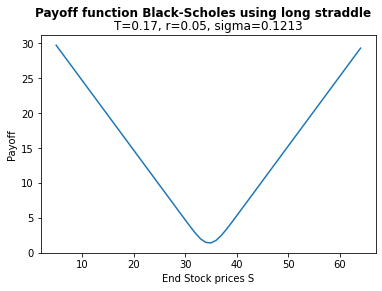

In [41]:
K1 = 35 # Strike price
straddle_payoffs = [OptionStrategies.long_straddle(S, K1, T, r, sigma) for S in end_prices]
plt.plot(end_prices, straddle_payoffs)
plt.xlabel('End Stock prices S')
plt.ylabel('Payoff')
plt.title(f'T={round(T, 2)}, r={r}, sigma={round(sigma, 4)}')
plt.suptitle('Payoff function Black-Scholes using long straddle', weight='bold', fontsize=12);

### Strangle

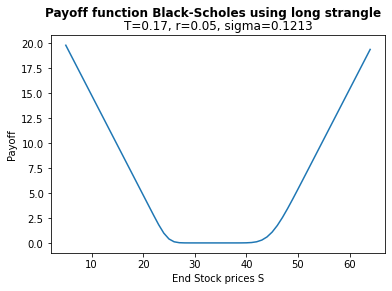

In [42]:
K1, K2 = 25, 45 # Strike prices
strangle_payoffs = [OptionStrategies.long_strangle(S, K1, K2, T, r, sigma) for S in end_prices]
plt.plot(end_prices, strangle_payoffs)
plt.xlabel('End Stock prices S')
plt.ylabel('Payoff')
plt.title(f'T={round(T, 2)}, r={r}, sigma={round(sigma, 4)}')
plt.suptitle('Payoff function Black-Scholes using long strangle', weight='bold', fontsize=12);

### Butterfly

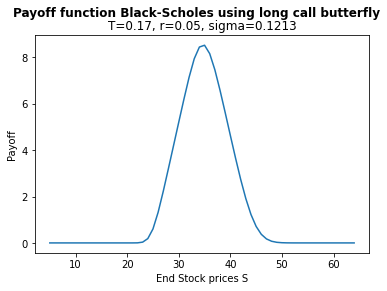

In [43]:
K1, K2, K3 = 25, 35, 45 # Strike prices
butterfly_payoffs = [OptionStrategies.long_call_butterfly(S, K1, K2, K3, T, r, sigma) for S in end_prices]
plt.plot(end_prices, butterfly_payoffs)
plt.xlabel('End Stock prices S')
plt.ylabel('Payoff')
plt.title(f'T={round(T, 2)}, r={r}, sigma={round(sigma, 4)}')
plt.suptitle('Payoff function Black-Scholes using long call butterfly', weight='bold', fontsize=12);

### Iron Condor

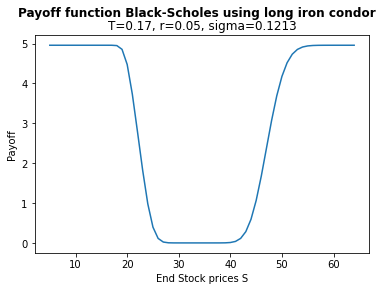

In [44]:
K1, K2, K3, K4 = 20, 25, 45, 50 # Strike prices
iron_condor_payoffs = [OptionStrategies.long_iron_condor(S, K1, K2, K3, K4, T, r, sigma) for S in end_prices]
plt.plot(end_prices, iron_condor_payoffs)
plt.xlabel('End Stock prices S')
plt.ylabel('Payoff')
plt.title(f'T={round(T, 2)}, r={r}, sigma={round(sigma, 4)}')
plt.suptitle('Payoff function Black-Scholes using long iron condor', weight='bold', fontsize=12);

## Custom payoff function

Financial instruments can get more complex than the trading strategies we just discussed. These products often have daunting names like [Barrier options](https://www.investopedia.com/terms/b/barrieroption.asp), [Asian options](https://en.wikipedia.org/wiki/Asian_option), [Bermudan options](https://www.investopedia.com/terms/b/bermuda.asp), [Mountain Range options](https://www.investopedia.com/terms/m/mountain_range_option.asp#:~:text=Key%20Takeaways-,Mountain%20range%20options%20are%20a%20family%20of%20exotic%20options%20based,individual%20securities%20in%20the%20basket.) and [Structured products](https://www.investopedia.com/articles/optioninvestor/07/structured_products.asp). Sometimes investors even feel the need to trade [options on options](https://www.investopedia.com/terms/c/compoundoption.asp)! As financial wizards we would like to able to do calculations with an arbitrary option strategy. The purpose of this can be for example to increase [leverage](https://www.investopedia.com/terms/l/leverage.asp) or hedge against specific risks.

Let's say an investment bank has made some crazy financial instrument for you that combines call and put options according to a payoff function $\alpha C(K)^{\alpha P(K)}/(\beta + P(K))^{C(K)}$ where $\alpha=3$ and $\beta=1$. Using Black-Scholes and Python we can set up something to visualize its payoff.

In [45]:
def payoff_function(end_prices: np.ndarray, K: int, T: float, r: float, sigma: float, 
                    alpha: int = 3, beta: int = 1):
    """ Some crazy custom payoff function """
    call_prices = np.array([BlackScholes().call_price(s, K, T, r, sigma) for s in end_prices])
    put_prices = np.array([BlackScholes().put_price(s, K, T, r, sigma) for s in end_prices])
    return alpha * call_prices**(alpha*put_prices) / (beta + put_prices)**(beta*call_prices)
  
K = 35 # Strike price
T = 1 # Time till expiration (in years)
r = 0.05 # Risk-free interest rate
end_prices = np.arange(30, 50, 0.1)
payoffs = payoff_function(end_prices, S, T, r, sigma)

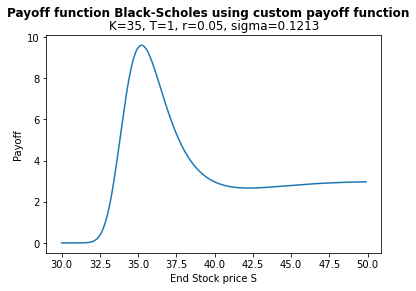

In [46]:
plt.plot(end_prices, payoffs)
plt.xlabel('End Stock price S')
plt.ylabel('Payoff')
plt.title(f'K={K}, T={round(T, 2)}, r={r}, sigma={round(sigma, 4)}')
plt.suptitle('Payoff function Black-Scholes using custom payoff function', weight='bold', fontsize=12);

## Stochastic differential equation (Wiener process)

![](https://memegenerator.net/img/instances/59439515.jpg)

We have talked a lot about the Black-Scholes model, but not so much about the mathematical justification that led to the formula. It is not crucial that you know the mathematics in order to use Black-Scholes, but it does allow you to think about the formula in a general way and to adapt it to other financial situations. Feel free to skip this part if you are only interested in the code and computing the formula.

As early as 1900, the French Mathematician [Louis Bachelier](https://mathshistory.st-andrews.ac.uk/Biographies/Bachelier/) modeled stock movement according to "[Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion)", which basically means random. The insight that a stock price can be described by [Geometric Brownian Motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) as a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process) is the first building block of the Black-Scholes formula. It allows us to set up the following Stochastic Differential equation (SDE):

$dS_t = \mu S_tdt + \sigma S_t d W_t$, where $W_t \sim \mathcal{N}(0, t)$ is the Wiener process.

The next important component for the Black-Scholes formula was discovered around 1950 and is called [Ito's lemma](https://en.wikipedia.org/wiki/It%C3%B4%27s_lemma), which allows us to solve an SDE for an Ito process, which is the case for Black-Scholes:

For an Ito process $dX_t = \mu S_tdt + \sigma S_t d W_t$

Through Ito's lemma, for any twice differentiable function $F(x, t)$, we get

$dF(x,t) = (\mu \frac{\partial F}{\partial x} + \frac{\partial F}{\partial t} + \frac{1}{2} \sigma_t^2 \frac{\partial^2 F}{\partial x^2})dt + \sigma_t \frac{\partial F}{\partial x} d W_t$.

The basic Black-Scholes model makes an additional set of assumptions:

1. There are no transaction costs
2. No dividends are involved
3. One can easily borrow and lend cash at the risk-free interest rate $r_f$.
4. One can buy fractions of assets.
5. There are no restrictions on short selling (like share borrowing costs).

We now have enough tools to derive SDE's involving Wiener processes. Let's take an example to show the full derivation of some Wiener Process using Ito's Lemma.

### Example of deriving stochastic differential equation

Let $W_t$ be a Wiener process at time $t, t \geq 0$.

For $t \geq 0, X_t = t^{\alpha}e^{\beta + \gamma W_t}$, with $\alpha, \beta$ and $\gamma$ as known constants.

We apply Ito's Lemma to compute the stochastic differential equation $dX_t$.



Let $dS_t = \mu S_t dt + \sigma S_t d W_t$, where $\mu = 0$ and $\sigma = \sigma_t^2 = 1$ (Standard normal distribution), then:

\begin{equation}
F(w, t)=t^{\alpha} e^{\beta+\gamma w} \\
\frac{\partial F}{\partial w} = \gamma  t^{\alpha}  e^{\beta+\gamma  w} = \gamma F \\
\frac{\partial F}{\partial t} = \alpha  t^{\alpha-1}  e^{\beta+\gamma  w} = \alpha \frac{1}{t} t^{\alpha}e^{\beta+\gamma  w} = \alpha t^{-1} F\\
\frac{\partial^{2} F}{\partial w^{2}} = \gamma^{2}t^{\alpha}  e^{\beta+\gamma  w} = \gamma^{2} F
\end{equation}



\begin{equation} 
\begin{split}
dX_{t} & = dF(w, t) \\
 & = (\mu_{t} \frac{\partial F}{\partial w} + \frac{\partial F}{\partial t} + \frac{1}{2} \sigma_{t}^{2}  \frac{\partial^{2} F}{\partial w^{2}}) dt + \sigma_{t} \frac{\partial F}{\partial w} dW_{t} \\
 & = (0 \frac{\partial F}{\partial w} + \frac{\partial F}{\partial t} + \frac{1}{2}  1   \frac{\partial^{2} F}{\partial w^{2}}) dt + 1 \frac{\partial F}{\partial w} dW_{t} \\
 & = (0 + \alpha t^{-1} F  + \frac{1}{2}  \gamma^{2} F) dt + \gamma F dW_{t} \\
 & = (\alpha t^{-1}  + \frac{1}{2}  \gamma^{2})F dt + \gamma F dW_{t} \\
 & = (\alpha t^{-1}  + \frac{1}{2}  \gamma^{2})X_{t} dt + \gamma X_{t} dW_{t}
\end{split}
\end{equation}

## Value-at-Risk (VaR)

![](https://www.azquotes.com/picture-quotes/quote-a-99-value-at-risk-calculation-does-not-evaluate-what-happens-in-the-last-one-percent-david-einhorn-134-56-74.jpg)

Value at risk (VaR) expresses how much of our investment we can lose within a given confidence interval, for example 95%. Note that this requires us to assume a probability distibution. Often (log-)normal distributions are used for finance applications. Here we give a simple example if we assume returns are normally distributed using. Note that it can be dangerous to rely on this as often we don't know the exact distribution or parameters of an investment. It is likely that we could lose much more than VaR indicates. VaR can only inform us about ordinary fluctuations of an asset.

For more information about VaR you can read this series by Investopedia ([Part1](https://www.investopedia.com/articles/04/092904.asp), [Part2](https://www.investopedia.com/articles/04/101304.asp)).

In [47]:
# Characteristics of portfolio
initial_investment = 100_000
portfolio_mean = 0.2 # Average Returns
portfolio_std = np.sqrt(0.044) # Standard deviation of portfolio

# Compute statistics for portfolio
mean_investment = (1 + portfolio_mean) * initial_investment
std_investment = portfolio_std * initial_investment

# Cutoff point in distribution for several confidence intervals (95%, 98% and 99%)
cutoff1 = norm.ppf(0.05, mean_investment, std_investment)
cutoff2 = norm.ppf(0.02, mean_investment, std_investment)
cutoff3 = norm.ppf(0.01, mean_investment, std_investment)

# Calculate VaR for several confidence intervals
VaR5 = initial_investment - cutoff1
VaR2 = initial_investment - cutoff2
VaR1 = initial_investment - cutoff3

In [48]:
print(f"The total value at risk (VaR) with 95% confidence is: {VaR5.round(2)}")
print(f"The total value at risk (VaR) with 98% confidence is: {VaR2.round(2)}")
print(f"The total value at risk (VaR) with 99% confidence is: {VaR1.round(2)}")

The total value at risk (VaR) with 95% confidence is: 14502.74
The total value at risk (VaR) with 98% confidence is: 23079.8
The total value at risk (VaR) with 99% confidence is: 28797.88


## Downside Risk

In the rare case that we have knowledge of the underlying distribution we can compute the downside risk. This would be more informative than VaR, since as prudent investors we are mainly interested in what we can lose in an extreme scenario.
We define the downside risk as:

$D \approx \sigma \sqrt{(1+\delta^2)\Phi(-\delta) - \delta\phi(\delta)}$

with $\mathcal{G}_1 = log(S_t/S_o)$ and where, $\Phi{.}$ is the CDF of the standard normal distribution, $\phi$ the PDF of the standard normal distribution, $\delta = P_f\sqrt{t}$ and $P_f=(v - r_f)/\sigma$. $v$ denotes drift, $r_f$ the risk-free interest rate, $\sigma$ the standard deviation and $t$ the time index, which usually denotes years.

In [49]:
def downside_risk(drift, r, sigma, t):
    """ Calculate the approximate downside risk. """
    delta = (drift - r) / sigma * np.sqrt(t)
    return sigma * np.sqrt((1 + delta**2) * norm.cdf(-delta) - delta * norm.pdf(delta)) 

In this example we define drift as $v = r_f - \frac{1}{2}\sigma^2$.

In [50]:
sigma = 1/68
r = 0.05
drift = r - 0.5 * sigma**2
t = 1

In [51]:
dr = downside_risk(drift, r, sigma, t)
print(f"The downside risk is: {round(dr*100, 4)}%")

The downside risk is: 1.046%


Note that the formula is extremely sensitive to the choice of distribution and therefore has limited practical applicability in the noisy world of finance. Do not be fooled by the elegant formulas and precise numbers that VaR and downside risk give. Good risk management is a complex topic in itself, which is outside the scope of this notebook. If you are interested in learning quantitative risk management I can highly recommend [this online course by Pasquale Cirillo](https://www.youtube.com/playlist?list=PLgCR5H4IzggHyHw8dalrVHqHAqZfmTeWa).

## The Greeks (Black-Scholes)

![](https://i.redd.it/bioues6bwfy31.jpg)

UPDATE: After this notebook I started formalizing this code into a library called [blackscholes](https://github.com/CarloLepelaars/blackscholes). Check out that library if you are looking to apply the concepts presented here.


An option portfolio can have different dimensions of risk exposure which we would like to manage as an option trader. There are a lot of risk dimensions in option portfolio's, but traders tend to focus on 5 core dimensions which are termed "The Greeks". They can be described as follows:

Delta $\Delta$: Rate of change in option price with respect to the underlying stock price (1st derivative). 

Gamma $\Gamma$: Rate of change in delta with respect to the underlying stock price (2nd derivative). 

Vega $\mathcal{V}$: Rate of change in option price with respect to the volatility ($\sigma$) of the stock price. The funny thing is Vega is not a Greek letter, but somehow Vega ended up in what people call The Greeks. $\mathcal{V}$ is actually the Greek letter "Nu".

Theta $\Theta$: Rate of change in option price with respect to time (i.e. time decay). In general the price of an option decreases over time given that all other values stay the same. The speed of this time decay differs based on the characteristics of an option and changes as time progresses.

Rho $\mathrm{P}$: Rate of change in option price with respect to interest rate. This value is often small and not so big of an issue in practice, unless we have long-term options that are already deep in-the-money as changes in interest rate will greatly affect the value of the option.

Calculation of the Greeks differs slightly between call and put options. Gamma and Vega are calculated the same for calls and puts. 

To simplify things we will exclude the influence of annual stock dividends denoted by parameter $q$ (except for the greek Epsilon). The original five Greeks have versions which integrates the dividend yield, but this makes the formulas unnecessarily complex for an introduction. If you want to explore how the core Greeks are calculated with dividends check out https://en.wikipedia.org/wiki/Greeks_(finance).

We further assume that we calculate the Greeks at time $t=0$. In other words, right as the option is written.

The formula's for calculating The Greeks are defined as follows:

$S_t$ = Stock price at time $t$, 

$K$ = Strike price of option, 

$T$ is time until expiration in years, 

$r$ = risk-free interest rate $\sigma$ = standard deviation (i.e. volatility), 

$\Phi$ is the Cumulative Density Function (CDF) of the standard normal distribution ($N(0, 1)$),

$\phi$ is the Probability Density Function (PDF) of $N(0, 1)$.

$d_1^{(t)} = \frac{1}{\sigma \sqrt{T}}[ln(\frac{S_t}{K}) + (r+\frac{\sigma^2}{2})T]$

$d_2^{(t)} = d_1^{(t)} - \sigma \sqrt{T}$

**Call options (C)**

Delta ($\Delta$) = $\frac{\partial C}{\partial S} = \Phi(d_1^{(t)})$

Gamma ($\Gamma$) = $\frac{\partial^2 C}{\partial S^2} = \frac{\phi(d_1^{(t)})}{S \sigma \sqrt{T}}$

Vega ($\mathcal{V}$) = $\frac{\partial C}{\partial \sigma} = S \phi(d_1^{(t)})\sqrt{T}$

Theta $(\Theta)$ = $\frac{\partial C}{\partial t} = -\frac{S\phi(d_1^{(t)}) \sigma}{2 \sqrt{T}} - rKe^{-rT}\Phi(d_2^{(t)})$

Rho ($\mathrm{P}$) = $\frac{\partial C}{\partial r} = KTe^{-rT}\Phi(d_2^{(t)})$

**Put options (P)**

Delta ($\Delta$) = $\frac{\partial P}{\partial S} = \Phi(d_1^{(t)}) - 1$

Gamma ($\Gamma$) = $\frac{\partial^2 P}{\partial S^2} = \frac{\phi(d_1^{(t)})}{S \sigma \sqrt{T}}$

Vega ($\mathcal{V}$) = $\frac{\partial P}{\partial \sigma} = S \phi(d_1^{(t)})\sqrt{T}$

Theta $(\Theta)$ = $\frac{\partial P}{\partial t} = -\frac{S\phi(d_1^{(t)}) \sigma}{2 \sqrt{T}} - rKe^{-rT}\Phi(-d_2^{(t)})$

Rho ($\rho$) = $\frac{\partial P}{\partial r} = -KTe^{-rT}\Phi(-d_2^{(t)})$

### Advanced: Down the Greek rabbit hole

While the five Greeks discussed above are still the core dimensions, further research and the rise in computing power has led us into exploring more complex dimensions. This allows us to hedge a lot more sophistically and develop trading strategies to profit from very specific situations. Here are some of the more obscure Greeks.

#### Lambda

Lambda ($\lambda$) is the percentage change in option value per percentage change in the underlying price, also called gearing.

Lambda call = $\frac{\partial C}{\partial S} \times \frac{S}{C} = \Delta \frac{S}{C}$.

Lambda put = $\frac{\partial P}{\partial S} \times \frac{S}{P} = \Delta \frac{S}{P}$.

#### Epsilon

Epsilon ($\epsilon$) is the percentage change in option value per percentage change in the underlying dividend yield. It informs us about the risk in our option portfolio regarding changes in dividend yield. 

Epsilon call = $\frac{\partial C}{\partial q}$ = $-ST e^{-qT} \Phi(d_1^{(t)})$

Epsilon put = $\frac{\partial P}{\partial q}$ = $ST e^{-qT} \Phi(-d_1^{(t)})$

#### Vanna

Vanna is the change is Vega per percentage change of the underlying stock price.

Vanna = $\frac{\partial \mathcal{C}}{\partial S}$ = $-\phi(d_1^{(t)}) \frac{d_2^{(t)}}{\sigma}$

Vanna is calculated the same for calls and puts.

#### Charm

Charm (delta decay) denotes the rate of change of delta over time.

Charm = $\frac{\partial^2 C}{\partial T \partial S}$ = $-\phi(d_1^{(t)}) \frac{2rT - d_2^{(t)}\sigma \sqrt{T}}{2T\sigma \sqrt{T}}$

Charm is calculated the same for calls and puts except if dividends are included.

#### Vomma

Vomma computes the second order effect of volatility (vega). More clearly, it can be described as "vega convexity".

Vomma = $\frac{\partial^2 C}{\partial \sigma^2}$ = $S \phi(d_1^{(t)})\sqrt{T}\frac{d_1^{(t)} d_2^{(t)}}{\sigma}$ = $\mathcal{V}\frac{d_1^{(t)} d_2^{(t)}}{\sigma}$

Since Vega is the same for calls and puts, the same is the case for Vomma.

#### Veta

Veta shows the rate of change in vega with respect to time.

Veta = $\frac{\partial^2 C}{\partial \sigma \partial T}$ = $-S \phi(d_1^{(t)}) \sqrt{T} (\frac{r d_1^{(t)}}{\sigma \sqrt{T}} - \frac{1+d_1^{(t)} d_2^{(t)}}{2 T})$

Veta is calculated the same for calls and puts.

#### Speed

Speed is the rate of change in Gamma ($\Gamma$) with respect to changes in underlying asset price. This makes it a third-order effect.


Speed = $\frac{\partial^3 C}{\partial S^3}$ = $\frac{\partial \Gamma}{\partial S}$ = $\frac{\phi(d_1^{(t)})}{S^2 \sigma \sqrt{T}}(\frac{d_1^{(t)}}{\sigma \sqrt{T}} + 1)$

It is calculated the same for calls and puts, since Gamma is also the same for calls and puts.

#### Zomma

Zomma measure the rate of change of gamma with respect to change in volatility. Note that this is a third order greek and can be used to monitor the effectiveness of gamma hedging in an option portfolio. 

Zomma = $\frac{\partial^3 C}{\partial S^2 \partial \sigma}$ =  $\frac{\partial \Gamma}{\partial \sigma}$ = $\frac{\phi(d_1^{(t)})(d_1^{(t)}d_2^{(t)}-1)}{S \sigma^2 \sqrt{T}}$

Again it is calculated the same for calls and puts, since Gamma is also the same for calls and puts.


#### Color

Color is gamma's rate of change with respect to time. It can also be thought of the gamma per year.

Color = $\frac{\partial^3 C}{\partial S^2 \partial T} = \frac{\partial \Gamma}{\partial T} = \frac{\phi(d_1^{(t)})}{2ST\sigma\sqrt{T}}[2T + 1 + \frac{2rT - d_2^{(t)}\sigma \sqrt{T}}{\sigma \sqrt{T}}d_1^{(t)}]$

It is calculated the same for calls and puts.

#### Ultima

The last greek we will discuss, Ultima, is a third order greek on the option volatility. More technically, it measures the sensitivity of vomma with respect to volatility. Recall that Vomma measures the 2nd order effect of volatility and Vega the 1st order effect.

Ultima = $\frac{\partial^3 C}{\partial sigma^3} = \frac{\partial vomma}{\partial \sigma} = \frac{\mathcal{V}}{\sigma^2}[d_1 d_2 (1-d_1 d_2) + d_1^2 + d_2^2]$

Vega is the same for call and puts and as Ultima derives its value from Vega it is the same for calls and puts.

----------------------------------------------------------------------------------------
Below you will find Python implementations for all the mentioned Greeks.

In [52]:
class BlackScholesGreeks:
    """ 
    Class to calculate (European) call and put option greeks.
    
    :param S: Price of underlying stock
    :param K: Strike price
    :param T: Time till expiration (in years)
    :param r: Risk-free interest rate (0.05 indicates 5%)
    :param sigma: Volatility (standard deviation) of stock (0.15 indicates 15%)
    :param q: The annual dividend yield of a stock
    """
    @staticmethod
    def _d1(S, K, T, r, sigma):
        return (1 / (sigma * np.sqrt(T))) * (np.log(S/K) + (r + sigma**2 / 2) * T)
    
    def _d2(self, S, K, T, r, sigma):
        return self._d1(S, K, T, r, sigma) - sigma * np.sqrt(T)
    
    def call_delta(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        return norm.cdf(d1)
    
    def call_gamma(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        return norm.pdf(d1) / (S * sigma * np.sqrt(T))
    
    def call_vega(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        return S * norm.pdf(d1) * np.sqrt(T)
    
    def call_theta(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return - ((S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))) - r * K * np.exp(-r*T) * norm.cdf(d2)
    
    def call_rho(self, S, K, T, r, sigma):
        d2 = self._d2(S, K, T, r, sigma)
        return K * T * np.exp(-r*T) * norm.cdf(d2)
    
    def call_epsilon(self, S, K, T, r, sigma, q):
        d1 = self._d1(S, K, T, r, sigma)
        return -S * T * np.exp(-q*T) * norm.cdf(d1)
    
    def put_delta(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        return norm.cdf(d1) - 1
    
    def put_gamma(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        return norm.pdf(d1) / (S * sigma * np.sqrt(T))
    
    def put_vega(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        return S * norm.pdf(d1) * np.sqrt(T)
    
    def put_theta(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return - ((S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))) + r * K * np.exp(-r*T) * norm.cdf(-d2)
    
    def put_rho(self, S, K, T, r, sigma):
        d2 = self._d2(S, K, T, r, sigma)
        return - K * T * np.exp(-r*T) * norm.cdf(-d2)
    
    def put_epsilon(self, S, K, T, r, sigma, q):
        d1 = self._d1(S, K, T, r, sigma)
        return S * T * np.exp(-q*T) * norm.cdf(-d1)
    
    def vanna(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return norm.pdf(d1) * d2 / sigma
    
    def charm(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return -norm.pdf(d1) * ((2 * r * T - d2 * sigma * np.sqrt(T)) / (2 * T * sigma * np.sqrt(T)))
    
    def vomma(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return S * norm.pdf(d1) * np.sqrt(T) * ((d1 * d2) / sigma)
    
    def veta(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return -S * norm.pdf(d1) * np.sqrt(T) * (r * d1 / (sigma * np.sqrt(T)) - (1 + d1 * d2) / (2 * T))
    
    def zomma(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return norm.pdf(d1) * (d1*d2 - 1) / (S * sigma**2 * np.sqrt(T))
    
    def color(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        return norm.pdf(d1) / (2*S*T*sigma*np.sqrt(T)) * (2*T + 1 + ((2*r*T - d2*sigma*np.sqrt(T)) / sigma*np.sqrt(T)) * d1)
    
    def ultima(self, S, K, T, r, sigma):
        d1 = self._d1(S, K, T, r, sigma)
        d2 = self._d2(S, K, T, r, sigma)
        vega = self.call_vega(S, K, T, r, sigma)
        return -vega/sigma**2 * (d1 * d2 * (1-d1*d2) + d1**2 + d2**2)

In [53]:
S = 36 # Stock price
K = 35 # Strike price
T = 2/12 # Time till expiration (in years)
r = 0.05 # Risk-free interest rate
sigma = np.sqrt(1/68) # Volatility (standard deviation)

### 5 Core Greeks

In [54]:
print("----- Call option -----")
print(f"Delta: {BlackScholesGreeks().call_delta(S, K, T, r, sigma)}")
print(f"Gamma: {BlackScholesGreeks().call_gamma(S, K, T, r, sigma)}")
print(f"Vega: {BlackScholesGreeks().call_vega(S, K, T, r, sigma)}")
print(f"Theta: {BlackScholesGreeks().call_theta(S, K, T, r, sigma)}")
print(f"Rho: {BlackScholesGreeks().call_rho(S, K, T, r, sigma)}")

----- Call option -----
Delta: 0.7770006122976156
Gamma: 0.16742428402928158
Vega: 4.385486164316654
Theta: -2.917805075810147
Rho: 4.407833779613507


In [55]:
print("----- Put option -----")
print(f"Delta: {BlackScholesGreeks().put_delta(S, K, T, r, sigma)}")
print(f"Gamma: {BlackScholesGreeks().put_gamma(S, K, T, r, sigma)}")
print(f"Vega: {BlackScholesGreeks().put_vega(S, K, T, r, sigma)}")
print(f"Theta: {BlackScholesGreeks().put_theta(S, K, T, r, sigma)}")
print(f"Rho: {BlackScholesGreeks().put_rho(S, K, T, r, sigma)}")

----- Put option -----
Delta: -0.22299938770238437
Gamma: 0.16742428402928158
Vega: 4.385486164316654
Theta: -1.1823278136921145
Rho: -1.3770904274466018


### Advanced Greeks

In [56]:
q = 0.05 # 5% annual dividend yield

In [57]:
print(f"Call epsilon: {BlackScholesGreeks().call_epsilon(S, K, T, r, sigma, q)}")
print(f"Put epsilon: {BlackScholesGreeks().put_epsilon(S, K, T, r, sigma, q)}")
print(f"Vanna: {BlackScholesGreeks().vanna(S, K, T, r, sigma)}")
print(f"Charm: {BlackScholesGreeks().charm(S, K, T, r, sigma)}")
print(f"Vomma: {BlackScholesGreeks().vomma(S, K, T, r, sigma)}")
print(f"Veta: {BlackScholesGreeks().veta(S, K, T, r, sigma)}")
print(f"Zomma: {BlackScholesGreeks().zomma(S, K, T, r, sigma)}")
print(f"Color: {BlackScholesGreeks().color(S, K, T, r, sigma)}")
print(f"Ultima: {BlackScholesGreeks().ultima(S, K, T, r, sigma)}")

Call epsilon: -4.623315069580461
Put epsilon: 1.326892686252795
Vanna: 1.7534291743210113
Charm: 0.3365398498736247
Vomma: 19.639414810264917
Veta: 16.925898290489435
Zomma: -0.6308439620252236
Color: 0.645712879273512
Ultima: -398.6324962578006


## Option pricing with dividends

We can adjust the Black-Scholes formula to account for dividends. Most of the formula will stay the same, but we now have an additional parameter $q$, indicating the annual dividend yield. The Black-Scholes model assumes that the underlying share price drops when a dividend is paid as money is taken out of the underlying business. Therefore, a dividend is discounted by multiplying parts of the formula by $e^{-qT}$.

$S_t$ = Stock price at time $t$, $K$ = Strike price of option, $T$ is time till expiration in years, $r$ = risk-free interest rate $\sigma$ = standard deviation (i.e. volatility), $q$=Annual dividend yield.

$\Phi$ is the Cumulative Density Function (CDF) of the standard normal distribution ($N(0, 1)$).


$C(S_t, t) = \Phi(d_1^{(t)})S_t e^{-qT} - \Phi(d_2^{(t)})Ke^{-rT}$

$P(S_t, t) = \Phi(-d_2^{(t)})Ke^{-rT} - \Phi(-d_1^{(t)})S_t e^{-qT}$

where $d_1^{(t)} = \frac{1}{\sigma \sqrt{T}}[ln(\frac{S_t e^{-qT}}{K}) + (r+\frac{\sigma^2}{2})T]$

$d_2^{(t)} = d_1^{(t)} - \sigma \sqrt{T}$

In [58]:
class BlackScholesDividend:
    """ 
    Class to calculate (European) call and put option prices through the Black-Scholes formula 
    with dividends
    
    :param S: Price of underlying stock
    :param K: Strike price
    :param T: Time till expiration (in years)
    :param r: Risk-free interest rate (0.05 indicates 5%)
    :param sigma: Volatility (standard deviation) of stock (0.15 indicates 15%)
    :param q: Annual dividend yield (0.05 indicates 5%)
    """
    @staticmethod
    def _d1(S, K, T, r, sigma, q):
        return (1 / (sigma * np.sqrt(T))) * (np.log(S * np.exp(-q*T) / K) + (r + sigma**2 / 2) * T)
    
    def _d2(self, S, K, T, r, sigma, q):
        return self._d1(S, K, T, r, sigma, q) - sigma * np.sqrt(T)
    
    def call_price(self, S, K, T, r, sigma, q):
        """ Main method for calculating price of a call option """
        d1 = self._d1(S, K, T, r, sigma, q)
        d2 = self._d2(S, K, T, r, sigma, q)
        return norm.cdf(d1) * S * np.exp(-q*T) - norm.cdf(d2) * K * np.exp(-r*T)
    
    def put_price(self, S, K, T, r, sigma, q):
        """ Main method for calculating price of a put option """
        d1 = self._d1(S, K, T, r, sigma, q)
        d2 = self._d2(S, K, T, r, sigma, q)
        return norm.cdf(-d2) * K * np.exp(-r*T) - norm.cdf(-d1) * S * np.exp(-q*T)
    
    def call_in_the_money(self, S, K, T, r, sigma, q):
        """ 
        Calculate probability that call option will be in the money at
        maturity according to Black-Scholes.
        """
        d2 = self._d2(S, K, T, r, sigma, q)
        return norm.cdf(d2)
    
    def put_in_the_money(self, S, K, T, r, sigma, q):
        """ 
        Calculate probability that put option will be in the money at
        maturity according to Black-Scholes.
        """
        d2 = self._d2(S, K, T, r, sigma, q)
        return 1 - norm.cdf(d2)

In [59]:
S = 44 # Stock price
K = 45 # Strike price
T = 2/12 # Time till expiration (in years)
r = 0.06 # Risk-free interest rate
sigma = np.sqrt(0.2) # Volatility (standard deviation)
q = 0.05 # Annual dividend yield

In [60]:
BlackScholesDividend().call_price(S, K, T, r, sigma, q)

2.7692191859846638

In [61]:
BlackScholesDividend().put_price(S, K, T, r, sigma, q)

3.686604828586688

## BONUS: Speeding up option price calculations

You might have noticed that working with Black-Scholes involves computing the cumulative distribution function (CDF) ($\Phi(.)$) and probability density function (PDF) ($\phi(.))$ of a standard normal distribution $N(0, 1)$. The library we use for this (scipy.norm) does multiple checks under the hood and can therefore be sped up substantially. We also leverage some other tricks to optimize our calculations.

### 1. scipy.special.ndtr

The first trick is to replace [norm.cdf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) by [scipy.special.ndtr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.ndtr.html). ndtr is a function that norm.cdf also calls under the hood, but in this case we skip the datatype checks. Let's take the calculation of a call option's Theta as an example. We compare the run time with our original implementation from the section on The Greeks.

In [62]:
S = 36 # Stock price
K = 35 # Strike price
T = 2/12 # Time till expiration (in years)
r = 0.05 # Risk-free interest rate
sigma = np.sqrt(1/68) # Volatility (standard deviation)

In [63]:
from scipy.special import ndtr

def _d1(S, K, T, r, sigma):
    return (1 / (sigma * np.sqrt(T))) * (np.log(S/K) + (r + sigma**2 / 2) * T)
    
def _d2(S, K, T, r, sigma):
    return _d1(S, K, T, r, sigma) - sigma * np.sqrt(T)
    
def fast_theta(S, K, T, r, sigma):
    d1 = _d1(S, K, T, r, sigma)
    d2 = _d2(S, K, T, r, sigma)
    return - ((S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))) - r * K * np.exp(-r*T) * ndtr(d2)

In [64]:
bsg = BlackScholesGreeks()
bsg.call_theta(S, K, T, r, sigma)

-2.917805075810147

In [65]:
%%timeit
bsg.call_theta(S, K, T, r, sigma)

243 µs ± 2.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [66]:
fast_theta(S, K, T, r, sigma)

-2.917805075810147

In [67]:
%%timeit
fast_theta(S, K, T, r, sigma)

141 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### 2. norm._pdf

Voilà! An almost 2x speedup. Now we can further speed it up by replacing norm.pdf by norm._pdf. Note that this skips a few checks and we have to take care that our input variables are valid.

In [68]:
def faster_theta(S, K, T, r, sigma):
    d1 = _d1(S, K, T, r, sigma)
    d2 = _d2(S, K, T, r, sigma)
    return - ((S * norm._pdf(d1) * sigma) / (2 * np.sqrt(T))) - r * K * np.exp(-r*T) * ndtr(d2)

In [69]:
faster_theta(S, K, T, r, sigma)

-2.917805075810147

In [70]:
%%timeit
faster_theta(S, K, T, r, sigma)

17.1 µs ± 229 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### 3. JIT compilation with Numba

An substantial speedup! Now for the nerds who have not fallen asleep yet, we can go one step further to compute this thing in a few hundred nanoseconds. Note that we use a lot of NumPy function and basic operations in our calculation. Therefore, we can leverage [just in time (JIT) compilation with Numba](http://numba.pydata.org/) to speed up the computation. This requires us to reimplement the Scipy functions from scratch.

In [71]:
from math import erf
from numba import jit

@jit
def pdf_phi(x):
    """ PDF of standard normal distribution """
    return np.exp(-x**2/2) / np.sqrt(2*np.pi)

@jit
def cdf_phi(x):
    """ CDF of standard normal distribution """
    return (1. + erf(x / np.sqrt(2.))) / 2.

@jit
def _d1(S, K, T, r, sigma):
    return (1 / (sigma * np.sqrt(T))) * (np.log(S/K) + (r + sigma**2 / 2) * T)
    
@jit
def _d2(S, K, T, r, sigma):
    return _d1(S, K, T, r, sigma) - sigma * np.sqrt(T)

@jit
def faster_theta_jit(S, K, T, r, sigma):
    d1 = _d1(S, K, T, r, sigma)
    d2 = _d2(S, K, T, r, sigma)
    return - ((S * pdf_phi(d1) * sigma) / (2 * np.sqrt(T))) - r * K * np.exp(-r*T) * cdf_phi(d2)

In [72]:
faster_theta_jit(S, K, T, r, sigma)

-2.917805075810147

In [73]:
%%timeit
faster_theta_jit(S, K, T, r, sigma)

620 ns ± 2.14 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


And that is one last 35x speedup over the last version! Most functions that feature basic operations or a lot of NumPy can be transformed with JIT compilation, but the speedup may not be that large in some cases.

## Follow-ups

If you are interested in learning more about quantitative finance, here are some resources I would recommend you check out.

### Video material

[Patrick Boyle On Finance (Video playlists on Financial Mathematics and awesome finance channel in general)](https://www.youtube.com/c/PatrickBoyleOnFinance)

[Quantatative Risk Management course by Pasquale Cirillo](https://www.youtube.com/c/PatrickBoyleOnFinance)

### Books

**Textbooks:**

Investment Science - David Luenberger

[Python for Finance - Yves Hilpisch](https://www.oreilly.com/library/view/python-for-finance/9781492024323/)

**(Auto)biographies:**

My life as a quant - Emanuel Derman

A Man For All Markets: From Las Vegas to Wall Street, How I Beat the Dealer and the Market - Edward Thorp

The Man Who Solved The Market: How Jim Simons Launched the Quant Revolution - Gregory Zuckerman

## Courses

[Udacity - Machine Learning for Trading](https://www.udacity.com/course/machine-learning-for-trading--ud501)

[Udacity - Artifial Intelligence for trading (paid Nanodegree program)](https://www.udacity.com/course/ai-for-trading--nd880)

And don't forget:

![](https://i.pinimg.com/originals/07/48/40/07484051f93b50545e090eb302f6adc2.jpg)

That's it! I hope this notebook gave you a clear overview of core concepts in financial mathematics and quantitative finance!

If you have any questions or feedback, feel free to comment and/or upvote the notebook below. You can also contact me on Twitter [@carlolepelaars](https://twitter.com/carlolepelaars).

Oh, and give the [blackscholes](https://github.com/CarloLepelaars/blackscholes) library a start on Github. I will be implementing option-related functionality this is discussed in this notebook. [blackscholes](https://github.com/CarloLepelaars/blackscholes) also has clear documentation and tests for each component.

In [1]:
def calc_ITM_coveredcall(p, c , k , t):
    return (k / (p-c))**(365/t) -1 

In [2]:
calc_ITM_coveredcall(353.68, 27.7 , 332, 64)

0.1100012452797654

In [4]:
(1 + 0.0185)**(365/64)

1.1102039501748309